In [1]:
import os
import math

import torch
import jax
import jax.numpy as jnp
import numpy as np

from typing import Optional
from accelerate import Accelerator
from itertools import pairwise

from smalldiffusion import Unet, Scaled, ScheduleLogLinear, samples as sd_gen_samples

import jax

import jax.numpy as jnp

from gnx.util.pytorch_convert import convert_unet
from gnx.methods.noise_schedule import NoiseSchedule
from gnx.methods.integrators import AccelDDIM, Euler, DDIM, DDPM
from gnx.methods.diffusion import DiffusionModel, NoisingForwardProcess

from gnx.util.experiment import Image

In [2]:
@torch.no_grad()
def gen_samples(
    model: torch.nn.Module,
    key: jax.Array,
    sigmas: torch.FloatTensor,  # Iterable with N+1 values for N sampling steps
    gam: float = 1.0,  # Suggested to use gam >= 1
    mu: float = 0.0,  # Requires mu in [0, 1)
    accelerator: Optional[Accelerator] = None,
):
    model.eval()
    accelerator = accelerator or Accelerator()
    input_shape: tuple[int, ...] = model.input_dims  # type: ignore
    init_key, n_key = jax.random.split(key)
    keys = jax.random.split(n_key, len(sigmas))
    # use NHWC
    init_noise = jax.random.normal(
        init_key, shape=input_shape[1:] + (input_shape[0],)
    ).transpose((2, 0, 1))
    xt = torch.tensor(np.copy(init_noise)).unsqueeze(0) * sigmas[0]
    yield xt / math.sqrt(sigmas[0] ** 2 + 1), None
    # model.eval()
    # accelerator = accelerator or Accelerator()
    # batchsize = 1
    # xt = model.rand_input(batchsize).to(accelerator.device) * sigmas[0]
    eps = None
    for i, ((sig, sig_prev), key) in enumerate(zip(pairwise(sigmas), keys)):
        eps_prev, eps = eps, model.predict_eps_cfg(xt, sig.to(xt), None, 0.0)  # type: ignore
        eps_av = eps * gam + eps_prev * (1 - gam) if i > 0 else eps  # type: ignore
        sig_p = (sig_prev / sig**mu) ** (
            1 / (1 - mu)
        )  # sig_prev == sig**mu sig_p**(1-mu)
        eta = (sig_prev**2 - sig_p**2).sqrt()

        noise = jax.random.normal(
            key, shape=input_shape[1:] + (input_shape[0],)
        ).transpose((2, 0, 1))
        noise = torch.tensor(np.copy(noise)).unsqueeze(0)
        xt = xt - (sig - sig_p) * eps_av + eta * noise
        yield xt / math.sqrt(sig_prev**2 + 1), eps

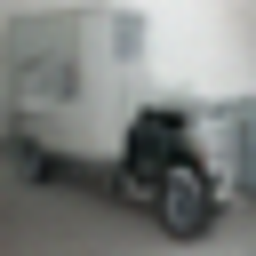

In [3]:
a = Accelerator()
torch_model = Scaled(Unet)(  # type: ignore
    32, 3, 3, ch=128, ch_mult=(1, 2, 2, 2), attn_resolutions=(16,)  # type: ignore
)
params = torch.load("../../models/checkpoint.pth", map_location="cpu")
torch_model.load_state_dict(params)
sample_schedule = ScheduleLogLinear(sigma_min=0.01, sigma_max=35, N=1000)
torch_output = gen_samples(
    torch_model,
    jax.random.key(42),
    sample_schedule.sample_sigmas(10),
    gam=1.0, mu=0.,
    accelerator=a,
)
torch_traj, torch_eps = zip(*list(torch_output))
torch_eps = torch_eps[1:]
torch_eps = torch.stack(torch_eps).cpu().numpy().squeeze(1).transpose((0, 2, 3, 1)) # fmt: skip
torch_traj = torch.stack(torch_traj).cpu().numpy().squeeze(1).transpose((0, 2, 3, 1)) # fmt: skip

# torch_xt = torch.stack(torch_xt, dim=0).cpu().numpy().transpose((0, 2, 3, 1))
# torch_x0 = torch_x0.cpu().numpy().transpose((1, 2, 0))
Image((torch_traj[-1] + 1) / 2, display_size=(256, 256))

In [4]:
schedule = NoiseSchedule.log_linear_noise(0.01, 35).constant_variance()

diffuser, _ = convert_unet(
    jax.tree.map(lambda x: jnp.array(x.cpu().numpy()), torch_model.state_dict()),
    schedule,
)
diffuser.eval()

euler_model = DiffusionModel(
    diffuser,
    NoisingForwardProcess(schedule, jnp.zeros((32, 32, 3))),
    integrator=Euler(),
    nfe=100,
)
ddim_model = DiffusionModel(
    diffuser,
    NoisingForwardProcess(schedule, jnp.zeros((32, 32, 3))),
    integrator=DDIM(),
    nfe=100,
)

In [5]:
def gen_samples_jax(
    diffuser,
    key: jax.Array,
    sigmas: jax.Array,  # Iterable with N+1 values for N sampling steps
    gam: float = 1.0,  # Suggested to use gam >= 1
    mu: float = 0.0,  # Requires mu in [0, 1)
):
    shape = (32, 32, 3)
    init_key, n_key = jax.random.split(key)
    keys = jax.random.split(n_key, len(sigmas))
    # use NHWC
    init_noise = jax.random.normal(
        init_key, shape=shape
    )
    xt = init_noise * sigmas[0]
    yield xt / math.sqrt(sigmas[0] ** 2 + 1), None
    eps = None
    for i, ((sig, sig_prev), key) in enumerate(zip(pairwise(sigmas), keys)):
        t = schedule.inverse(sig)
        eps_prev, eps = eps, diffuser(xt / math.sqrt(sig ** 2 + 1), t=t)  # type: ignore
        eps_av = eps * gam + eps_prev * (1 - gam) if i > 0 else eps  # type: ignore
        sig_p = (sig_prev / sig**mu) ** (
            1 / (1 - mu)
        )  # sig_prev == sig**mu sig_p**(1-mu)
        eta = np.sqrt(sig_prev**2 - sig_p**2)

        noise = jax.random.normal(key, shape=shape)
        xt = xt - (sig - sig_p) * eps_av + eta * noise
        yield xt / math.sqrt(sig_prev**2 + 1), eps

In [6]:
jax_traj, jax_eps = zip(*gen_samples_jax(diffuser, jax.random.key(42), sample_schedule.sample_sigmas(100).cpu().numpy()))
jax_eps = jax_eps[1:]

In [7]:
jax_traj = jnp.stack(jax_traj, axis=0)
jax_eps = jnp.stack(jax_eps, axis=0)

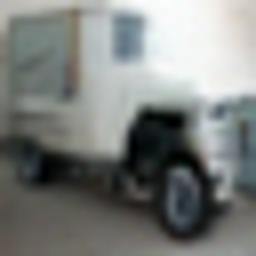

In [8]:
Image((jax_traj[-1] + 1) / 2, display_size=(256, 256))

In [9]:
ddim_traj = ddim_model.sample(jax.random.key(42), path=True)
euler_traj = euler_model.sample(jax.random.key(42), path=True)

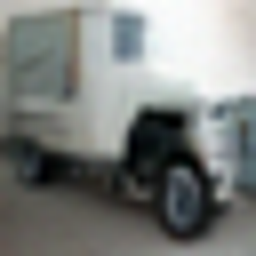

In [10]:
Image((ddim_traj[-1] + 1) / 2, display_size=(256, 256))

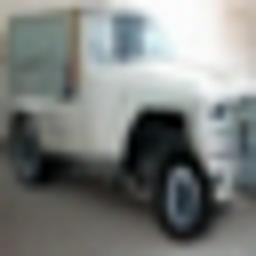

In [11]:
Image((euler_traj[-1] + 1) / 2, display_size=(256, 256))

In [12]:
print(np.max(np.abs(ddim_traj[:] - euler_traj[:]), axis=(1,2,3)))
print(np.max(np.abs(torch_traj[:] - ddim_traj[:]), axis=(1,2,3)))

[0.00000000e+00 8.34465027e-05 1.73568726e-04 2.70366669e-04
 3.74794006e-04 4.89950180e-04 6.16073608e-04 7.54833221e-04
 9.10282135e-04 1.08504295e-03 1.28269196e-03 1.50656700e-03
 1.76143646e-03 2.05302238e-03 2.38656998e-03 2.76875496e-03
 3.20720673e-03 3.70979309e-03 4.28700447e-03 4.94933128e-03
 5.70917130e-03 6.57868385e-03 7.57384300e-03 8.71086121e-03
 1.00054741e-02 1.14758015e-02 1.31380558e-02 1.50098801e-02
 1.71058178e-02 1.94358826e-02 2.20055580e-02 2.48122215e-02
 2.78437138e-02 3.10738087e-02 3.44631672e-02 3.79576683e-02
 4.14898396e-02 4.51179743e-02 5.00246286e-02 5.51865101e-02
 6.05483055e-02 6.60248995e-02 7.24723935e-02 7.91368484e-02
 8.57509375e-02 9.21493173e-02 9.81903076e-02 1.03749275e-01
 1.08753562e-01 1.13170296e-01 1.32972956e-01 1.54242456e-01
 1.75914586e-01 1.97635591e-01 2.19075143e-01 2.39932060e-01
 2.59955764e-01 2.78952241e-01 2.96785295e-01 3.13372672e-01
 3.28677416e-01 3.42691123e-01 3.55432868e-01 3.66939008e-01
 3.77260178e-01 3.864581

TypeError: sub got incompatible shapes for broadcasting: (11, 32, 32, 3), (101, 32, 32, 3).